In [180]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
import pandas as pd
import torch
import gc
import Stemmer
import re
from tqdm import tqdm
import csv
import gc
import networkx as nx
from utils.preprocessing import preprocess_text
from utils.graph import KGraphPreproc

In [282]:
s = fbkb_graph._graph.edges(data=True)

In [283]:
list(s)[:10]

[('/m/027rn', '/m/06cx9'),
 ('/m/027rn', '/m/0l6ny'),
 ('/m/027rn', '/m/09nqf'),
 ('/m/027rn', '/m/026wp'),
 ('/m/027rn', '/m/02lq67'),
 ('/m/027rn', '/m/02j71'),
 ('/m/027rn', '/m/06sks6'),
 ('/m/027rn', '/m/02lq5w'),
 ('/m/027rn', '/m/0kbws'),
 ('/m/027rn', '/m/02lpp7')]

In [187]:
fbkb_graph = KGraphPreproc.get_fbkb_graph()

In [188]:
triplets = fbkb_graph._get_entity_knowledge("/m/0c9k8", depth=1)
triplets[:5]

['Reds /film/film/genre Drama',
 'Reds /award/award_winning_work/awards_won./award/award_honor/award BAFTA_Award_for_Best_Actor_in_a_Supporting_Role',
 'Reds /award/award_winning_work/awards_won./award/award_honor/award_winner Jack_Nicholson',
 'Reds /award/award_category/nominees./award/award_nomination/nominated_for Academy_Award_for_Best_Production_Design',
 'Reds /award/award_category/nominees./award/award_nomination/nominated_for Academy_Award_for_Best_Sound_Mixing']

In [189]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

In [193]:
def node_query_similarity(query, node):
    print(node)
    return 0
    return model.similarity(
        *model.encode([query, node])
    )

In [ ]:
from collections import deque

def bfs_triplet_similarity(graph, query, start_node, width):
    """
    BeamSearch over KG.
    Exploring `width` branches from a node
    Query-Triplet embedding similarity is a scoring function
    """
    queue = deque([start_node])
    visited = set()
    result = []

    while queue:
        current = queue.popleft()
        if current in visited:
            continue
        visited.add(current)
        # add top 5 triplets
        if graph.
        # 


In [259]:
query = "Who was the first Roman Catholic to become American President?"
start_node = "/m/060d2"
target_node = "/m/0d3k14"
N = 3

In [196]:
bfs = nx.bfs_beam_edges(
    fbkb_graph._graph, 
    source=start_node,
    value=lambda n: node_query_similarity(query, n),
    width=N,
)

### Collect similarity of each triplet edge along the way
### scatterplot the similarities

In [260]:
subgraph = nx.bfs_tree(fbkb_graph._graph, source=start_node, depth_limit=N)

In [265]:
len(subgraph.edges)

12764

In [262]:
edge_sim_df = pd.DataFrame(columns=["start", "end", "depth", "similarity", "emnbedding"])
edge_sim_df

,start,end,depth,similarity


In [263]:
# Compute the depth of each node
depth = nx.single_source_shortest_path_length(fbkb_graph._graph, start_node)
# Annotate each edge in the BFS tree
for i, (u, v) in enumerate(list(subgraph.edges)):
    edge_sim_df.loc[i] = [u, v, depth[v], 0]
    # bfs_tree[u][v]['depth'] = depth[v]
edge_sim_df

,start,end,depth,similarity
0,/m/060d2,/m/0gfhg1y,1,0
1,/m/060d2,/m/08mbj5d,1,0
2,/m/0gfhg1y,/m/01cpjx,2,0
3,/m/0gfhg1y,/m/04gqr,2,0
4,/m/0gfhg1y,/m/02mjmr,2,0
...,...,...,...,...
12759,/m/017575,/m/019m5j,3,0
12760,/m/01q_22,/m/0djgt,3,0
12761,/m/0bkv0,/m/01m3dv,3,0
12762,/m/01r9nk,/m/0847q,3,0


In [272]:
!pip install bm25s

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
632849.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [264]:
for i, r in tqdm(edge_sim_df.iterrows()):
    src = r.start
    sink = r.end
    relation = fbkb_graph._graph[src][sink]["relation"]
    s = fbkb_graph.mid2name[src]
    o = fbkb_graph.mid2name[sink]
    triplet = f"{s} {relation} {o}"
    sim = round(float(model.similarity(
        *model.encode([query, triplet])
    )[0][0]), 5)
    edge_sim_df.at[i, "similarity"] = sim
edge_sim_df.head()

0it [00:00, ?it/s]

/tmp/ipykernel_2170/1244169983.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.22322' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  edge_sim_df.at[i, "similarity"] = sim
12764it [01:02, 202.98it/s]


,start,end,depth,similarity
0,/m/060d2,/m/0gfhg1y,1,0.22322
1,/m/060d2,/m/08mbj5d,1,0.27369
2,/m/0gfhg1y,/m/01cpjx,2,0.05348
3,/m/0gfhg1y,/m/04gqr,2,0.02005
4,/m/0gfhg1y,/m/02mjmr,2,0.16118


In [270]:
s_path = nx.shortest_path(fbkb_graph._graph, start_node, target_node)
s_path

['/m/060d2', '/m/08mbj5d', '/m/0rh6k', '/m/0d3k14']

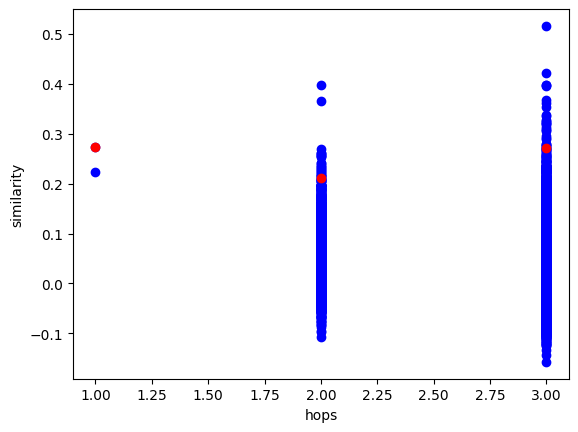

In [271]:
import matplotlib.pyplot as plt
plt.scatter(edge_sim_df.depth, edge_sim_df.similarity, color='blue', label='Data Points')
for s, t in zip(s_path, s_path[1:]):
    path = edge_sim_df[(edge_sim_df["start"] == s) & (edge_sim_df["end"] == t)].iloc[0]
    plt.scatter(path.depth, path.similarity, c="red")
# Add labels and title
plt.xlabel('hops')
plt.ylabel('similarity')
# plt.title('Scatter Plot Example')
# Show plot
plt.show()

In [268]:
nx.shortest_path(fbkb_graph._graph, start_node, target_node)

['/m/060d2', '/m/08mbj5d', '/m/0rh6k', '/m/0d3k14']

Perf degradation with the increase in number of hops
but with my heuristics:
- I can go up to N+1
- Perf increase

[Traversing Knowledge Graphs in Vector Space](https://aclanthology.org/D15-1038.pdf)

[KNOWLEDGE SOLVER: TEACHING LLMS TO SEARCH FOR
DOMAIN KNOWLEDGE FROM KNOWLEDGE GRAPHS](https://www.semanticscholar.org/reader/d60bc65862c9aca2b4c18595cc1d0f34cadaf4cf)

!!! [Think on Graph](https://arxiv.org/pdf/2307.07697)